In [2]:
#Math Part
import numpy as np
import pandas as pd

#Graph
import matplotlib.pyplot as plt

import importlib
import circuit
import encoding
import qsvm
import fitness
import gsvm
importlib.reload(circuit)
importlib.reload(encoding)
importlib.reload(qsvm)
importlib.reload(fitness)
importlib.reload(gsvm)

import pandas as pd
import time


In [3]:

def evol(output="bank_testdata.csv"):
    iot_data = pd.read_csv('bank_cleaned.csv').iloc[11500:12000]
    y = iot_data['y'].values
    X = iot_data[['age','job','marital','education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']].values
    start = time.time()
    pop, pareto, logbook = gsvm.gsvm(nqubits=4, depth=3, nparameters=2,
                                     X=X, y=y, weights=[-1.0,1.0],
                                     mu=50,lambda_=10, ngen=10)
    print(f'Simulation finished after {time.time()-start} seconds')
    print(f'\nGenetic-algorithm output ({output})')
    #print('generation, individual, gates/qubit, accuracy')
    print('---------------------------------------------')
    with open(output, "w") as f:
        for ide, ind in enumerate(pareto):
            genes=''.join(str(i) for i in list(ind))
            gates, acc = ind.fitness.values
            line = f'{ide},"{genes}",{gates},{acc}'
            f.write(line)
            f.write('\n')
            print(line)
evol()

multi
String: 001101100100101111001010011011111010100110110001111010010110
 -> accuracy = 0.94, gates = 8.0,recall =0.0
String: 000101011011010111011011000001001011010101000001000011011001
 -> accuracy = 0.94, gates = 9.0,recall =0.0
String: 110001010110101001011110110101101111000100111001000111101101
 -> accuracy = 0.94, gates = 10.0,recall =0.0
String: 011000101110111001101111010001001000010010011001001101111110
 -> accuracy = 0.94, gates = 13.0,recall =0.0
String: 011001100110000001101011010110001010101111001010010001100010
 -> accuracy = 0.94, gates = 8.0,recall =0.0
String: 101111001000111001111000010100110111110111100111001001101110
 -> accuracy = 0.94, gates = 11.0,recall =0.0
String: 110100000000111001100011111000101111010101001110110011101001
 -> accuracy = 0.94, gates = 9.0,recall =0.0
String: 110110011000110100101010010000101111110001000111011000000101
 -> accuracy = 0.94, gates = 11.0,recall =0.0
String: 101010001011100101010110011110001110100011111110001001100110
 -> accur

In [4]:
import encoding2 as e2
import random

iot_result = pd.read_csv('bank_testdata.csv',header=None)

def ordenar_salidas_pareto(dataframe):
    dataframe.columns=['ind','circ','gates','acc']
    dataframe.sort_values(['acc','gates'], ascending=[False,False],inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.pop('index')
    return dataframe

iot_salidas = ordenar_salidas_pareto(iot_result)
iot_salidas # Queremos ver el primer circuito del dataframe yya ordenado por accuracy (mejor ind)

,ind,circ,gates,acc
0,0,1100110011110001000011001110111011110100101101...,1.4127,0.94


['11001', '10011', '11000', '10000', '11001', '11011', '10111', '10100', '10110', '10011', '11011', '01000']
3.0


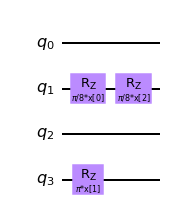

In [5]:
from qiskit.circuit import ParameterVector, QuantumCircuit, Parameter
from qiskit import execute, Aer, IBMQ, QuantumRegister, ClassicalRegister, BasicAer
#from qiskit.aqua import QuantumInstance
def coding_bits(b):
    c = [b[n:n+5] for n,i in enumerate(b) if n%5==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+5] for n,i in enumerate(c_p) if n%5==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = np.pi / (2**n)
            gates['000'+suffix] = (self.make_H(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

import os
import psutil

class Fitness:

    def __init__(self, nqubits, nparameters, X, y, quantum_instance):
        self.nqubits = nqubits
        self.nparameters = nparameters
        self.cc = CircuitConversor(nqubits, nparameters)
        self.instance = quantum_instance
        self.X = X
        self.y = y

    def __call__(self, POP):
        try:
            return self.fitness(POP)
        except Exception as e:
            print(f'Exception happened during fitness():\n  {e}')
            process = psutil.Process(os.getpid())
            print(f'  RUSAGE_SELF: {process.memory_info()}')
        return 1000, 100000.0

    def fitness(self, POP):
        print('Invoked fitness')
        #Convertimos el individuo en el fenotipo (ansatz)
        fm, puertas = self.cc(coding_bits(POP))
        
cc = CircuitConversor(nqubits=4, nparameters=3)
fm, puertas = cc(coding_bits(iot_salidas.circ[0]))
print(puertas)
fm.draw(output='mpl')

'000000100001010010011010100011101100100001001101111110110110'

In [14]:
bank_data = pd.read_csv('bank_cleaned.csv').iloc[25000:45000]

y = bank_data['y'].values
X = bank_data[['age','job','marital','education','default','balance',
               'housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']].values


In [16]:
def featuremap_results(pop:str,nqubits:int,nparameters:int):
    '''Returns the performance of a feature map on all of the dataset'''


    fitness_obj = fitness.Fitness(nqubits,nparameters,X,y,debug=True)

    model = fitness_obj(pop)

    return None

In [17]:
featuremap_results(iot_salidas.circ[0],4,3)

String: 110011001111000100001100111011101111010010110100111101101000
 -> accuracy = 0.8025, gates = 3.0,recall =0.0
